In [62]:
from scipy.stats import norm
from matplotlib import pyplot as plt 
import numpy as np
np.set_printoptions(threshold=np.inf)
np.set_printoptions(suppress = True)

In [16]:
#Init parameters
S0_init = 30       #S_0
K_init = 30        #Strike price (=S_0)
T_init = 10        #Maturity
v_init = 2         #Vesting period
r_init = 0.05      #RF rate
N_init = 10        #Height of tree
sigma_init = 0.3   #Volatility
m_init = 2         #Exercise multiple (m>1)

#For R option: alpha is percentage that gets converted to stock, gamma the "risk premium"
alpha_init = 0.75
gamma_init = 0.1


#Agent-level parameters
risk_init = 1.5 #>1 because agent is risk-averse

In [50]:
#Iso-elastic utility
def util(w, risk):  #TO-DO: handle log-utility case 
    if w==0:
        return 0
    else:
        return (w**(1-risk)) / (1-risk)


#Inverse of iso-elastic utility, needed to compute CE (input utility, returns wealth)
def u_minus(u, risk):
    if u==0:
        return 0
    else:
        return (u*(1-risk))**(1/(1-risk))

In [53]:
def rn_eso_CE(S0,K,T,v,r,N,sigma,m, risk):
    #Init values
    dt = 1/N                        #number of steps
    u = np.exp(sigma * np.sqrt(dt)) #using CRR method with (constant) volatility
    d = 1/u                         #to maintain the triangular structure of the tree (i.e., recombinant tree)
    q = (np.exp(r*dt) - d)/(u-d)    #q is the RN probability
    disc = np.exp(-r*dt)            #discount

  #Build up stock price tree (needed for next step)
    S = np.zeros(T*N+1)
    for j in range(0, T*N+1): #build up the nodes from the bottom
      S[j] = S0 * u**j * d**(T*N-j)

  #Utility if exercising at all nodes (when option is in-money)
    U = np.zeros(T*N+1)
    for j in range(0, T*N+1):
      w = max(0, S[j] - K)
      #print(w)
      U[j] = util(w, risk)

  #Backward recursion through the tree: at each node, is it optimal (in terms of utility) to exercise or not?
    for i in np.arange(T*N-1,-1,-1):
      for j in range(0,i+1):
        S = S0 * u**j * d**(i-j)                      #S is function of j (#ups) and i-j (#downs)
        vested = (i+j >= v*N)

        if not vested:                                #Unvested
          U[j] = disc * ( q*U[j+1] + (1-q)*U[j] )
        elif vested & (S>=K*m):                       #Vested and early exercisable (as function of multiple - )
          U[j] = util(S - K, risk)
        elif vested & (S<K*m):                        #Vested but unexercisable (as function of multiple)
          U[j] = disc * ( q*U[j+1] + (1-q)*U[j] )

        #NON-VESTED case - Comment the ifs above and run the below
          #C[j] = disc * ( q*C[j+1] + (1-q)*C[j] )
          #C[j] = max(C[j], S - K)
    return u_minus(U[0], risk)

In [60]:
#print(u_minus(util(5.54356432,2),2))
#print(util(2,2.3))

#CE with RN option for different levels of risk aversion -> should be decreasing with risk aversion
rn1 = rn_eso_CE(S0_init,K_init,T_init,v_init,r_init,N_init,sigma_init,m_init, 1.1)

rn2 = rn_eso_CE(S0_init,K_init,T_init,v_init,r_init,N_init,sigma_init,m_init, 1.12)


print(rn1)
print(rn2)

0.8816418889113407
0.02139429600605729


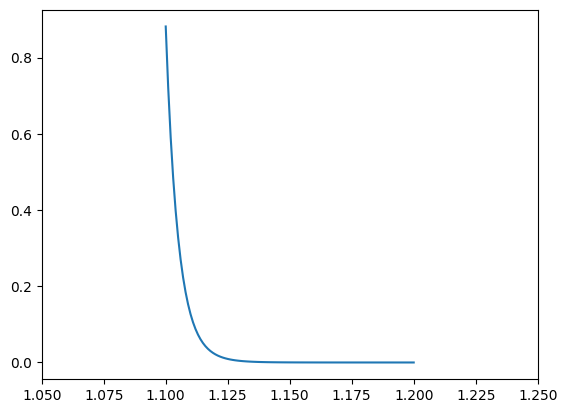

In [81]:
risks = np.zeros(101)
cert_eq = np.zeros(101)

for i in range(0, 101):
    risks[i] = 1.10+i/1000
    cert_eq[i] = rn_eso_CE(S0_init,K_init,T_init,v_init,r_init,N_init,sigma_init,m_init, risks[i])

plt.plot(risks, cert_eq)
plt.xlim(1.05, 1.25)

plt.show()